In [ ]:
output_t=activition(dot(state_t,Uo)+dot(input_t,Wo)+dot(C_t,Vo)+bo)

i_t=activation(dot(state_t,Ui)+dot(input_t,Wi)+bi)
f_t=activation(dot(state_t,Uf)+dot(input_t,Wf)+bf)
k_t=activation(dot(state_t,Uk)+dot(input_t,Wk)+bk)
#将其进行随机组合
c_t+1=i_t*k_t+c_t*f_t

In [17]:
from keras.datasets import imdb
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense
from keras.preprocessing import sequence

max_features=10000
maxlen=500
(input_train,y_train),(input_test,y_test)=imdb.load_data(num_words=max_features)
input_train=sequence.pad_sequences(input_train,maxlen=maxlen)

model=Sequential()
model.add(Embedding(max_features,32))
model.add(LSTM(32))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history=model.fit(input_train,y_train,epochs=10,batch_size=128,validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 84s 4ms/step - loss: 0.4942 - acc: 0.7688 - val_loss: 0.3989 - val_acc: 0.8334
Epoch 2/10
20000/20000 [==============================] - 78s 4ms/step - loss: 0.2933 - acc: 0.8832 - val_loss: 0.3007 - val_acc: 0.8716
Epoch 3/10
20000/20000 [==============================] - 78s 4ms/step - loss: 0.2294 - acc: 0.9148 - val_loss: 0.3250 - val_acc: 0.8834
Epoch 4/10
20000/20000 [==============================] - 78s 4ms/step - loss: 0.1988 - acc: 0.9257 - val_loss: 0.2915 - val_acc: 0.8742
Epoch 5/10
20000/20000 [==============================] - 77s 4ms/step - loss: 0.1760 - acc: 0.9362 - val_loss: 0.2953 - val_acc: 0.8770
Epoch 6/10
20000/20000 [==============================] - 79s 4ms/step - loss: 0.1596 - acc: 0.9429 - val_loss: 0.3645 - val_acc: 0.8474
Epoch 7/10
20000/20000 [==============================] - 79s 4ms/step - loss: 0.

In [1]:
import os

data_dir='C:/Users/SHESHE/Desktop'
fname=os.path.join(data_dir,'jena_climate_2009_2016.csv')

f=open(fname)
data=f.read()
f.close()

lines=data.split('\n')
header=lines[0].split(',')
lines=lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
import numpy as np

float_data=np.zeros((len(lines),len(header)-1))
for i,line in enumerate(lines):
    values=[float(x) for x in line.split(',')[1:]]
    float_data[i,:]=values

In [3]:
from matplotlib import pyplot as plt

temp=float_data[:,1]
plt.plot(range(len(temp)),temp)

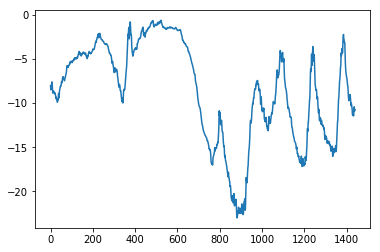

In [4]:
plt.plot(range(1440),temp[:1440])

In [5]:
mean=float_data[:200000].mean(axis=0)
float_data-=mean
std=float_data[:200000].std(axis=0)
float_data/=std

In [6]:
def generator(data,lookback,delay,min_index,max_index,shuffle=False,batch_size=128,step=6):
    if max_index is None:
        max_index=len(data)-delay-1
    i=min_index+lookback
    while 1:
        if shuffle:
            rows=np.random.randint(min_index+lookback,max_index,size=batch_size)
        else:
            if i+batch_size>=max_index:
                i=min_index+lookback
            rows=np.arange(i,min(i+batch_size,max_index))
            i+=len(rows)
            
        samples=np.zeros((len(rows),lookback//step,data.shape[-1]))
       
        targets=np.zeros((len(rows),))
        for j,row in enumerate(rows):
            indices=range(rows[j]-lookback,rows[j],step)
            samples[j]=data[indices]
            targets[j]=data[rows[j]+delay][1]
        yield samples,targets

In [7]:
lookback=1440
step=6
delay=144
batch_size=128

train_gen=generator(float_data,lookback=lookback,delay=delay,min_index=0,max_index=200000,shuffle=True,step=step,batch_size=batch_size)

val_gen=generator(float_data,lookback=lookback,delay=delay,min_index=200001,max_index=300000,step=step,batch_size=batch_size)

test_gen=generator(float_data,lookback=lookback,delay=delay,min_index=300001,max_index=None,step=step,batch_size=batch_size)

val_steps=(300000-200001-lookback)//batch_size

test_steps=(len(float_data)-300001-lookback)//batch_size

In [8]:
def evaluate_naive_method():
    batch_maes=[]
    for step in range(val_steps):
        samples,targets=next(val_gen)
        preds=samples[:,-1,1]
        mae=np.mean(np.abs(preds-targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [9]:
celsius_mae=0.29*std[1]

print(celsius_mae)

2.5672247338393395


In [10]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model=Sequential()
model.add(layers.Flatten(input_shape=(lookback//step,float_data.shape[-1])))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(),loss='mae')
history=model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,validation_steps=val_steps)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
500/500 [==============================] - 17s 33ms/step - loss: 1.2741 - val_loss: 0.7398
Epoch 2/20
500/500 [==============================] - 14s 28ms/step - loss: 0.3790 - val_loss: 0.3907
Epoch 3/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2843 - val_loss: 0.3279
Epoch 4/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2622 - val_loss: 0.3254
Epoch 5/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2501 - val_loss: 0.3118
Epoch 6/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2400 - val_loss: 0.3258
Epoch 7/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2337 - val_loss: 0.3135
Epoch 8/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2289 - val_loss: 0.3223
Epoch 9/20
500/500 [==============================] - 14s 28ms/s

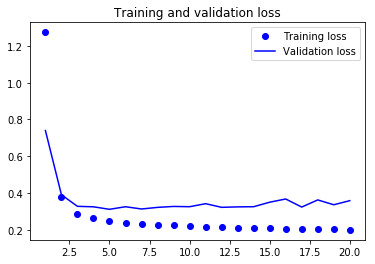

In [12]:
import matplotlib.pyplot as plt

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(loss)+1)

plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model=Sequential()
model.add(layers.GRU(32,input_shape=(None,float_data.shape[-1])))
model.add(layers.Dense(1))
          
model.compile(optimizer=RMSprop(),loss='mae')
history=model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 75s 150ms/step - loss: 0.3038 - val_loss: 0.2718
Epoch 2/20
500/500 [==============================] - 69s 138ms/step - loss: 0.2814 - val_loss: 0.2749
Epoch 3/20
500/500 [==============================] - 67s 135ms/step - loss: 0.2769 - val_loss: 0.2691
Epoch 4/20
500/500 [==============================] - 71s 141ms/step - loss: 0.2736 - val_loss: 0.2695
Epoch 5/20
500/500 [==============================] - 70s 140ms/step - loss: 0.2676 - val_loss: 0.2728
Epoch 6/20
500/500 [==============================] - 72s 144ms/step - loss: 0.2618 - val_loss: 0.2630
Epoch 7/20
500/500 [==============================] - 76s 153ms/step - loss: 0.2594 - val_loss: 0.2673
Epoch 8/20
500/500 [==============================] - 74s 147ms/step - loss: 0.2545 - val_loss: 0.2679
Epoch 9/20
500/500 [==============================] - 73s 146ms/step - loss: 0.2499 - val_loss: 0.2704
Epoch 10/20
500/500 [==============================] - 71s 141ms/step - l

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model=Sequential()
model.add(layers.GRU(32,dropout=0.2,recurrent_dropout=0.2,input_shape=(None,float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),loss='mae')
hitory=model.fit_generator(train_gen,steps_per_epoch=500,epochs=40,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 87s 173ms/step - loss: 0.3371 - val_loss: 0.2761
Epoch 2/40
500/500 [==============================] - 86s 173ms/step - loss: 0.3150 - val_loss: 0.2779
Epoch 3/40
500/500 [==============================] - 86s 173ms/step - loss: 0.3094 - val_loss: 0.2695
Epoch 4/40
500/500 [==============================] - 117s 233ms/step - loss: 0.3051 - val_loss: 0.2686
Epoch 5/40
500/500 [==============================] - 116s 232ms/step - loss: 0.3022 - val_loss: 0.2674
Epoch 6/40
500/500 [==============================] - 110s 220ms/step - loss: 0.2990 - val_loss: 0.2692
Epoch 7/40
500/500 [==============================] - 2269s 5s/step - loss: 0.2966 - val_loss: 0.2661
Epoch 8/40
500/500 [==============================] - 105s 210ms/step - loss: 0.2966 - val_loss: 0.2667
Epoch 9/40
500/500 [==============================] - 94s 188ms/step - loss: 0.2932 - val_loss: 0.2647
Epoch 10/40
500/500 [==============================] - 93s 186ms/step 

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model=Sequential()
model.add(layer.GRU(32,dropout=0.2,input_shape(None,float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),loss='mae')
history=model.fit_generator(train_gen,step_oer_eopch=500,epochs=40,validation_data=val_gen,validation_steps=val_steps)